# Data Science Workflow: Game of Thrones Example

This notebook is a demonstration of how a data scientist typically builds models, and how that process changes with Neo4J and connected data. I'll walk through an example of trying to predict which character will die next on Game of Thrones to demonstrate typical machine learning workflows:
*  Ingesting data
*  Data exploration, cleanup, and manipulation
*  Data preparation for machine learning
*  Model fitting, tuning, and performance 

I'll break down the workbook into two pieces: first, a simple model based on tabular (non graphy) data, then a version of the model with connected feature extraction where we examine whether or not relationships matter for making our predictions. 

Usually, in examples, I try to leave out the ugly bits (ingesting and merging files, encoding categorical data, messing around with feature engineering) but for this I'm going to try to show as much of my work as possible to show the actual work that goes into model building.

*Disclaimer:* I actually have no idea if we'll be able to build a good predictive model of who will die next, but it's worth a try!

### Supporting notebooks:
There are a few pieces of code I've placed in separate notebooks so they're available and there's transparency in how the data set was constructed.
*  GoT tabular data cleanup: this notebook creates the flat files for traditional ML predictions
*  GoT_graphbuild_code: this notebook constructs the neo4j graph we use to extract relationships and graph-based fatures

## Simple Tabular Data Predictions and Model
Let's start with the simplest data set: the tabular time invariant data (eg. is noble, house, gender). Since this is a toy problem, I won't do an exhaustive exploration but this should be sufficient to summarize the process. 

I'm going to use a random forest classifier to predict, based on various parameters, whether someone is *currently* alive or dead (as of the last book published). While a survival model (eg. cox proportional hazards) is more appropriate from a statistics perspective, I'm aiming for something everyone is familiar with and is straightforward to implement.

In [239]:
from py2neo import Graph
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, precision_score, recall_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')


In [300]:
tabular_data=pd.read_csv('Got_clean_tabular_data.csv')

#let's add a few binary variables to clean up our many categorical variables
tabular_data['known_culture']=1
tabular_data.loc[tabular_data['culture']=='Unknown','known_culture']=0
tabular_data['known_spouse']=1
tabular_data.loc[tabular_data['spouse']=='Unknown','spouse']=0
tabular_data['known_heir']=1
tabular_data.loc[tabular_data['heir']=='Unknown','known_heir']=0
tabular_data['known_mother']=1
tabular_data.loc[tabular_data['mother']=='Unknown','known_mother']=0
tabular_data['known_father']=1
tabular_data.loc[tabular_data['father']=='Unknown','known_father']=0

Does being a member of the nobility impact your likelihood of death?

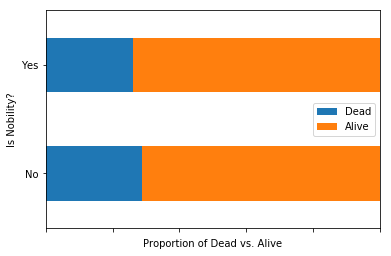

In [17]:
data=tabular_data.groupby(["nobility", "is_alive"]).count()["name"].unstack().copy(deep = True)
p = data.div(data.sum(axis = 1), axis = 0).plot.barh(stacked = True, rot = 0, width = .5)
_ = p.set_xlim([0, 1]), p.set(yticklabels = ["No", "Yes"], xticklabels = "", xlabel = "Proportion of Dead vs. Alive", ylabel = "Is Nobility?"), p.legend(["Dead", "Alive"])

What about gender?

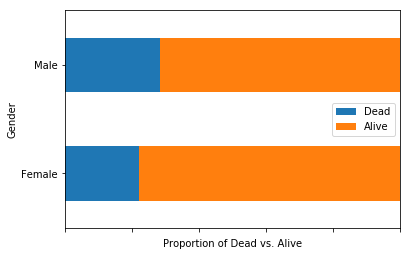

In [21]:
data=tabular_data.groupby(["gender", "is_alive"]).count()["name"].unstack().copy(deep = True)
p = data.div(data.sum(axis = 1), axis = 0).plot.barh(stacked = True, rot = 0, width = .5)
_ = p.set_xlim([0, 1]), p.set(yticklabels = ["Female", "Male"], xticklabels = "", xlabel = "Proportion of Dead vs. Alive", ylabel = "Gender"), p.legend(["Dead", "Alive"])

So far everything seems fairly equitable - the proportions of deaths aren't different between genders or nobles vs. non nobles. Maybe having dead relatives matters?

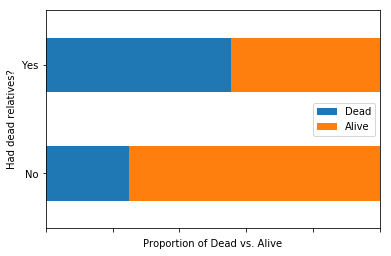

In [25]:
data=tabular_data.groupby(["has_dead_rels","is_alive"]).count()["name"].unstack().copy(deep = True)
p = data.div(data.sum(axis = 1), axis = 0).plot.barh(stacked = True, rot = 0, width = .5)
_ = p.set_xlim([0, 1]), p.set(yticklabels = ["No", "Yes"], xticklabels = "", xlabel = "Proportion of Dead vs. Alive", ylabel = "Had dead relatives?"), p.legend(["Dead", "Alive"])

Maybe cultures might be predictive?

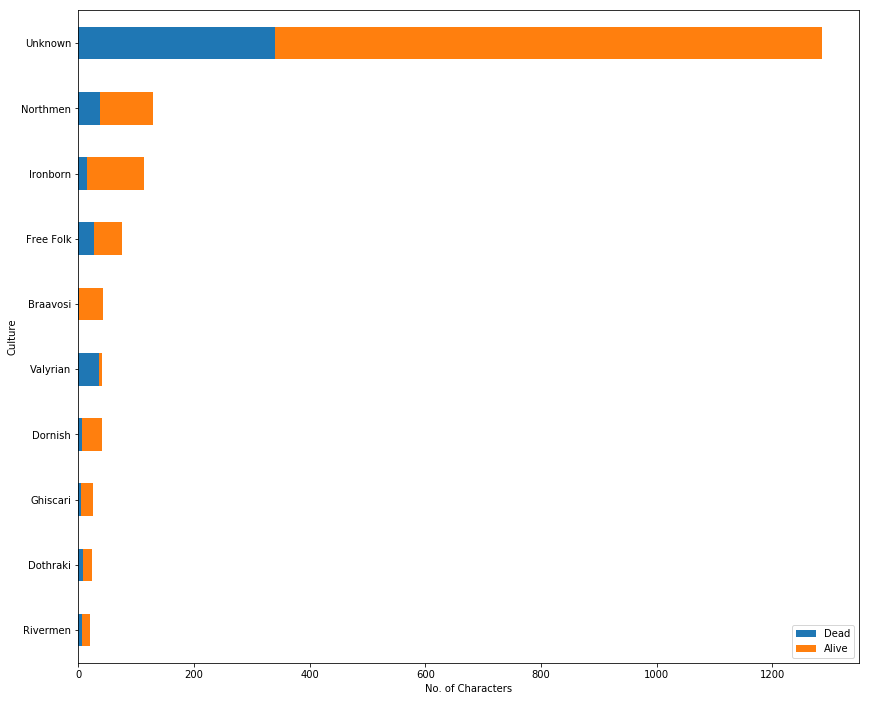

In [49]:
data=tabular_data.groupby(["culture","is_alive"]).count()["name"].unstack().copy(deep = True)
#data=data.loc[:, "total"]
data.loc[:, "total"]= data.sum(axis = 1)
list(data)
data=data[data['total']>20]
p = data[data.index != ""].sort_values("total")[[0, 1]].plot.barh(stacked = True, rot = 0, figsize = (14, 12),)
_ = p.set(xlabel = "No. of Characters", ylabel = "Culture"), p.legend(["Dead", "Alive"], loc = "lower right")

In the figure above, I filtered out any culturs with fewer than 20 characters to make it easier to read. It looks like, if you're a member of certain cultures you are all but certain to be alive or dead. Almost every Valyrian is dead, whereas almost every Braavosi is alive.

Taken together, I don't have a lot of hope that I'm going to be able to build a not terrible model, but it's worth trying! 

### Split the data into train and test

Let's start by identifying the relevant columns for our dependent and independent variables, encoding the categorical data

In [307]:
model_data=tabular_data[['is_alive','allegiances','nobility','culture','house','gender','has_Allegiance','has_dead_rels','mother','father','spouse','heir','data_poor']]
model_data=model_data.dropna()
# do we need to resample our data?
print("number living individuals:",len(model_data[model_data['is_alive']==1]))
print("number dead individuals:",len(model_data[model_data['is_alive']==0]))

number living individuals: 1427
number dead individuals: 532


In [308]:
#let's balance out our data
alive_model_data=model_data[model_data['is_alive']==1]
dead_model_data=model_data[model_data['is_alive']==0]
# we want equal numbers of living and dead individuals...
alive_downsampled=resample(alive_model_data,replace=False,n_samples=len(dead_model_data),random_state=42)
#merge the results back together
downsampled_model_data=dead_model_data.append(alive_downsampled)
print("number living individuals after resampling:",len(downsampled_model_data[downsampled_model_data['is_alive']==1]))
print("number dead individuals after resampling:",len(downsampled_model_data[downsampled_model_data['is_alive']==0]))

number living individuals after resampling: 532
number dead individuals after resampling: 532


In [309]:
X=downsampled_model_data[['allegiances','nobility','culture','house','gender','has_Allegiance','has_dead_rels','mother','father','spouse','heir','data_poor']]
X=pd.get_dummies(X)
y=downsampled_model_data['is_alive']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [311]:
classifier=RandomForestClassifier(n_estimators = 50, criterion='entropy', random_state=42,max_depth=8)
classifier.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [312]:
y_pred=classifier.predict(X_test)
print("Accuracy: ",accuracy_score(y_test,y_pred))
print("Precision: ",precision_score(y_test,y_pred))
print("Recall: ", recall_score(y_test,y_pred))
print("AUC: ",roc_auc_score(y_test,y_pred))

Accuracy:  0.6647727272727273
Precision:  0.6269430051813472
Recall:  0.7245508982035929
AUC:  0.6676808545072018


In [313]:
# let's tune the hyper parameters systematically and see what the best we can do is...
param_grid = { 
    'n_estimators': [10, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}
classifier_grid=RandomForestClassifier(random_state=42)
CV_rfc = GridSearchCV(estimator=classifier_grid, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)
CV_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'log2',
 'n_estimators': 500}

In [314]:
optimised_random_forest = CV_rfc.best_estimator_

In [315]:
#best_rfc=RandomForestClassifier(random_state=42, max_features='log2', n_estimators=500, max_depth=8, criterion='gini')
optimised_random_forest.fit(X_train,y_train)
y_pred=optimised_random_forest.predict(X_test)
print("Accuracy: ",accuracy_score(y_test,y_pred))
print("Precision: ",precision_score(y_test,y_pred))
print("Recall: ", recall_score(y_test,y_pred))
print("AUC: ",roc_auc_score(y_test,y_pred))

Accuracy:  0.6392045454545454
Precision:  0.5925925925925926
Recall:  0.7664670658682635
AUC:  0.6453956950962939


Let's visualize the results and see what the ROC curve looks like, and what variables were significant.

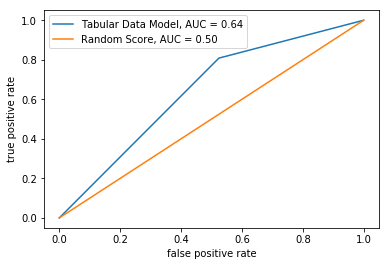

In [298]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.close()
plt.plot(fpr, tpr, label='Tabular Data Model, AUC = 0.64')
plt.plot([0,1],[0,1], label='Random Score, AUC = 0.50')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend(loc="bottom right")
plt.show()

In [316]:
# extract feature importance
feature_importance = pd.DataFrame(optimised_random_forest.feature_importances_, index=X_train.columns, columns=['importance']).sort_values('importance',ascending=False)
feature_importance.head(10)

,importance
data_poor,0.049642
house_House Targaryen,0.040668
has_dead_rels,0.040342
allegiances_Unknown,0.037945
culture_Valyrian,0.034057
has_Allegiance,0.028182
mother_Unknown,0.026151
allegiances_Wildling,0.025811
father_Unknown,0.024701
allegiances_Night's Watch,0.019901


So we have lots and lots of weekly predictive variables contributing to our predictions. Being data poor (along with having unknown spouse, allegiances, and heirs) is a big predictor - if we don't know much about you, I guess you're probably going to die. As we saw in our visualizations, culture also contributes significantly to your chances of survival.

Let's try visualizing one of the trees to get a sense of the interaction terms:

In [ ]:
# Extract single tree
estimator = classifier.estimators_[5]

# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = list(X),
                #class_names = list(y),
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz) - GraphViz must be installed seperately. On a mac, just use brew install graphviz
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

# Now - let's make it better with graphs!

70% accuracy isn't too bad, but we can certainly do better. There are two ways to add graph data: domain knowledge based feature engineering (eg. "how many hops is the shortest path between this person and Cersei?") and graph algorithms based features (PageRank, Louvain clusters, connectivity). 

Let's start by looking at the game of thrones graph and see what data we can add in.

## Query based feature engineering
We'll need to open a connection to neo4j. If you're on desktop, you'll have to have the GoT graph running in order to query it (otherwise) you just query whatever database is active.


In [127]:
# connect to neo4j 
password='password'
user='neo4j'
uri = 'bolt://localhost:7687'
got_graph=Graph(uri, auth=(user,password))

In [128]:
query='''
    MATCH (n) RETURN distinct labels(n), count(*)
'''

got_graph.run(query).to_data_frame()

,count(*),labels(n)
0,38,[Battle]
1,1332,[Person]
2,352,[House]
3,28,[Location]
4,7,[Region]
5,280,"[Person, Knight]"
6,104,"[Person, Dead, Knight]"
7,416,"[Person, Dead]"
8,9,"[Person, Dead, King]"
9,26,"[Person, King]"


In [129]:
query='''
    call db.relationshipTypes
'''

got_graph.run(query).to_data_frame()

,relationshipType
0,ATTACKER
1,DEFENDER
2,IS_IN
3,ATTACKER_COMMANDER
4,DEFENDER_COMMANDER
5,DEFENDER_KING
6,ATTACKER_KING
7,BELONGS_TO
8,HAS_STATUS
9,APPEARED_IN


let's start simple: for each person in our data set, how many people have they interacted with, and how many interactions have they had?

Since we've mapped to different data sources, we end up with a few multiples on names - let's clean that up by querying on both potential names and deleting any duplicates.

In [200]:
names=tabular_data['name character_deaths'].to_list()
query='''
    UNWIND $names as names
    MATCH(p:Person)-[r]-(p2:Person)
    WHERE p.name=names.name_char_preds
    RETURN p.name as name, names.name_char_preds as name_char_preds, sum(r.weight) as num_interactions ,count(distinct p2) as num_people_interacted
'''
names = [{"name":row["name"], "name_char_preds": row["name character_predictions"]} for index, row in tabular_data.iterrows()]    
result1=got_graph.run(query,{"names":names}).to_data_frame()
print(len(result1))
result1.head()

873


,name,name_char_preds,num_interactions,num_people_interacted
0,Melisandre,Melisandre,327,23
1,Quaithe,Quaithe,11,1
2,Cleon,Cleon,21,3
3,Ghael,Ghael,13,2
4,Kraznys mo Nakloz,Kraznys mo Nakloz,19,2


In [201]:
names=tabular_data['name character_predictions'].to_list()
query='''
    UNWIND $names as names
    MATCH(p:Person)-[r]-(p2:Person)
    WHERE p.name=names.name_char_deaths
    RETURN p.name as name_char_deaths, names.name as name, sum(r.weight) as num_interactions ,count(distinct p2) as num_people_interacted
'''
names = [{"name":row["name"], "name_char_deaths": row["name character_deaths"]} for index, row in tabular_data.iterrows()]    
result2=got_graph.run(query,{"names":names}).to_data_frame()
print(len(result2))
result2.head()

572


,name,name_char_deaths,num_interactions,num_people_interacted
0,Melisandre,Melisandre,327,23
1,Quaithe,Quaithe,11,1
2,Ghael,Ghael,13,2
3,Kraznys mo Nakloz,Kraznys mo Nakloz,19,2
4,Brusco,Brusco,16,2


In [202]:
results=pd.merge(result1, result2, right_on='name', left_on='name', how='outer')
results['num_interactions']=results['num_interactions_x']
results[results['name_char_preds'].isna()]['num_interactions']=results['num_interactions_y']
results['num_people_interacted']=results['num_people_interacted_x']
results[results['name_char_preds'].isna()]['num_people_interacted']=results['num_people_interacted_y']
results=results[['name','num_interactions','num_people_interacted']]
# and now lets add our results into our dataframe for predictions
graphy_data=tabular_data.merge(results,on='name',how='left')

Now let's check how many *dead* people each character has interacted with.

In [203]:
query='''
    UNWIND $names as names
    MATCH(p:Person)-[r]-(p2:Dead)
    WHERE p.name=names.name_char_preds
    RETURN p.name as name, names.name_char_preds as name_char_preds, sum(r.weight) as num_interactions_dead ,count(distinct p2) as num_people_interacted_dead
'''
names = [{"name":row["name"], "name_char_preds": row["name character_predictions"]} for index, row in tabular_data.iterrows()]    
result1=got_graph.run(query,{"names":names}).to_data_frame()


query='''
    UNWIND $names as names
    MATCH(p:Person)-[r]-(p2:Dead)
    WHERE p.name=names.name_char_deaths
    RETURN p.name as name_char_deaths, names.name as name, sum(r.weight) as num_interactions_dead ,count(distinct p2) as num_people_interacted_dead
'''
names = [{"name":row["name"], "name_char_deaths": row["name character_deaths"]} for index, row in tabular_data.iterrows()]    
result2=got_graph.run(query,{"names":names}).to_data_frame()

results=pd.merge(result1, result2, right_on='name', left_on='name', how='outer')
results['num_interactions_dead']=results['num_interactions_dead_x']
results[results['name_char_preds'].isna()]['num_interactions_dead']=results['num_interactions_dead_y']
results['num_people_interacted_dead']=results['num_people_interacted_dead_x']
results[results['name_char_preds'].isna()]['num_people_interacted_dead']=results['num_people_interacted_dead_y']
results=results[['name','num_interactions_dead','num_people_interacted_dead']]
graphy_data=graphy_data.merge(results,on='name',how='left')

Now let's start adding in some features from the graph algorithms library: I want to use some **pathfinding** algorithms to measure the shortest path between people and certain possibly risky acquaintences, **PageRank** to measure the importance of individuals in the graph, and **Louvain** to extract communities.

#### Djikstra's shortest path: Cersei, Daenerys, and Jon Snow
The Shortest Path algorithm calculates the shortest (weighted) path between a pair of nodes. In this category, Dijkstra’s algorithm is the most well known. It is a real time graph algorithm, and can be used as part of the normal user flow in a web or mobile application. For this effort, we're going with unweighted paths to get the number of hops.

In [209]:
# Djikstra's shortest path between each person and Daenery - warning, this is *slow* 
query='''
    UNWIND $names as names
    MATCH (start:Person{name:'Daenerys Targaryen'}),(end:Person{name:names.name_char_preds}) 
    CALL algo.shortestPath.stream(start,end,'cost',{
        nodeQuery: 'MATCH (p:Person) RETURN id(p) as id',
        relationshipQuery:'MATCH (p:Person)-[]-(p2:Person) RETURN id(p) as source, id(p2) as target',
        graph:'cypher', write:false, weightProperty:null})
    YIELD nodeId, cost
    RETURN end.name as name, names.name_char_preds, max(cost) as num_hops_daenerys
'''
names = [{"name":row["name"], "name_char_preds": row["name character_predictions"]} for index, row in tabular_data.iterrows()]    
result1=got_graph.run(query,{"names":names}).to_data_frame()

In [211]:
query='''
    UNWIND $names as names
    MATCH (start:Person{name:'Daenerys Targaryen'}),(end:Person{name:names.name_char_deaths}) 
    CALL algo.shortestPath.stream(start,end,'cost',{
        nodeQuery: 'MATCH (p:Person) RETURN id(p) as id',
        relationshipQuery:'MATCH (p:Person)-[]-(p2:Person) RETURN id(p) as source, id(p2) as target',
        graph:'cypher', write:false, weightProperty:null})
    YIELD nodeId, cost
    RETURN end.name as name, names.name_char_deaths, max(cost) as num_hops_daenerys
'''
names = [{"name":row["name"], "name_char_deaths": row["name character_deaths"]} for index, row in tabular_data.iterrows()]    
result2=got_graph.run(query,{"names":names}).to_data_frame()

In [217]:
results=pd.merge(result1, result2, right_on='name', left_on='name', how='outer')
results['num_hops_daenerys']=results['num_hops_daenerys_x']
results[results['names.name_char_preds'].isna()]['num_hops_daenerys']=results['num_hops_daenerys_y']
results=results[['name','num_hops_daenerys']]
results.head()
#graphy_data=graphy_data.merge(results,on='name',how='left')

,name,num_hops_daenerys
0,Melisandre,3.0
1,Quaithe,1.0
2,Cleon,1.0
3,Ghael,1.0
4,Kraznys mo Nakloz,1.0


In [218]:
#merge back into our data set
graphy_data=graphy_data.merge(results,on='name',how='left')

In [219]:
# Djikstra's shortest path between each person and Daenery - warning, this is *slow* 
query='''
    UNWIND $names as names
    MATCH (start:Person{name:'Cersei Lannister'}),(end:Person{name:names.name_char_preds}) 
    CALL algo.shortestPath.stream(start,end,'cost',{
        nodeQuery: 'MATCH (p:Person) RETURN id(p) as id',
        relationshipQuery:'MATCH (p:Person)-[]-(p2:Person) RETURN id(p) as source, id(p2) as target',
        graph:'cypher', write:false, weightProperty:null})
    YIELD nodeId, cost
    RETURN end.name as name, names.name_char_preds as name_char_preds, max(cost) as num_hops_cersei
'''
names = [{"name":row["name"], "name_char_preds": row["name character_predictions"]} for index, row in tabular_data.iterrows()]    
result1=got_graph.run(query,{"names":names}).to_data_frame()
query='''
    UNWIND $names as names
    MATCH (start:Person{name:'Cersei Lannister'}),(end:Person{name:names.name_char_deaths}) 
    CALL algo.shortestPath.stream(start,end,'cost',{
        nodeQuery: 'MATCH (p:Person) RETURN id(p) as id',
        relationshipQuery:'MATCH (p:Person)-[]-(p2:Person) RETURN id(p) as source, id(p2) as target',
        graph:'cypher', write:false, weightProperty:null})
    YIELD nodeId, cost
    RETURN end.name as name, names.name_char_deaths as name_char_deaths, max(cost) as num_hops_cersei
'''
names = [{"name":row["name"], "name_char_deaths": row["name character_deaths"]} for index, row in tabular_data.iterrows()]    
result2=got_graph.run(query,{"names":names}).to_data_frame()
results=pd.merge(result1, result2, right_on='name', left_on='name', how='outer')

results['num_hops_cersei']=results['num_hops_cersei_x']
results[results['name_char_preds'].isna()]['num_hops_cersei']=results['num_hops_cersei_y']
results=results[['name','num_hops_cersei']]
graphy_data=graphy_data.merge(results,on='name',how='left')

In [223]:
# Djikstra's shortest path between each person and Daenery - warning, this is *slow* 
query='''
    UNWIND $names as names
    MATCH (start:Person{name:'Jon Snow'}),(end:Person{name:names.name_char_preds}) 
    CALL algo.shortestPath.stream(start,end,'cost',{
        nodeQuery: 'MATCH (p:Person) RETURN id(p) as id',
        relationshipQuery:'MATCH (p:Person)-[]-(p2:Person) RETURN id(p) as source, id(p2) as target',
        graph:'cypher', write:false, weightProperty:null})
    YIELD nodeId, cost
    RETURN end.name as name, names.name_char_preds as name_char_preds, max(cost) as num_hops_jonsnow
'''
names = [{"name":row["name"], "name_char_preds": row["name character_predictions"]} for index, row in tabular_data.iterrows()]    
result1=got_graph.run(query,{"names":names}).to_data_frame()
query='''
    UNWIND $names as names
    MATCH (start:Person{name:'Jon Snow'}),(end:Person{name:names.name_char_deaths}) 
    CALL algo.shortestPath.stream(start,end,'cost',{
        nodeQuery: 'MATCH (p:Person) RETURN id(p) as id',
        relationshipQuery:'MATCH (p:Person)-[]-(p2:Person) RETURN id(p) as source, id(p2) as target',
        graph:'cypher', write:false, weightProperty:null})
    YIELD nodeId, cost
    RETURN end.name as name, names.name_char_deaths as name_char_deaths, max(cost) as num_hops_jonsnow
'''
names = [{"name":row["name"], "name_char_deaths": row["name character_deaths"]} for index, row in tabular_data.iterrows()]    
result2=got_graph.run(query,{"names":names}).to_data_frame()
results=pd.merge(result1, result2, right_on='name', left_on='name', how='outer')

results['num_hops_jonsnow']=results['num_hops_jonsnow_x']
results[results['name_char_preds'].isna()]['num_hops_jonsnow']=results['num_hops_jonsnow_y']
results=results[['name','num_hops_jonsnow']]
graphy_data=graphy_data.merge(results,on='name',how='left')

In [224]:
# now, before I forget, I'm going to fill the nas with 10 for these - we'll just assume anyone with an unknown number of hops is far away
graphy_data['num_hops_daenerys']=graphy_data['num_hops_daenerys'].fillna(value=10)
graphy_data['num_hops_cersei']=graphy_data['num_hops_cersei'].fillna(value=10)
graphy_data['num_hops_jonsnow']=graphy_data['num_hops_jonsnow'].fillna(value=10)

#### Centrality: PageRank
PageRank is an algorithm that measures the transitive influence or connectivity of nodes. It counts the number, and quality, of links to a node which determines an estimation of how important the node is. The underlying assumption is that nodes of importance are more likely to receive a higher volume of links from other nodes.

In [232]:
query='''
    CALL algo.pageRank.stream(
        'MATCH (p:Person) RETURN id(p) as id',
        'MATCH (p:Person)-[r]-(p2:Person) RETURN id(p) as source, id(p2) as target, sum(r.weight) as weight',
        {graph:'cypher', weightProperty:'weight',write:false})
    YIELD nodeId, score
    RETURN algo.asNode(nodeId).name AS name, score as pageRank
    ORDER BY pageRank DESC
'''
results=got_graph.run(query).to_data_frame()
results.head()

,name,pageRank
0,Jon Snow,27.444190
1,Tyrion Lannister,25.053686
2,Cersei Lannister,17.951240
3,Daenerys Targaryen,16.921242
4,Jaime Lannister,15.129903


In [233]:
graphy_data=graphy_data.merge(results,on='name',how='left')

#### Community Detection: Louvain

The Louvain method of community detection is an algorithm for detecting communities in networks. It maximizes a modularity score for each community, where the modularity quantifies the quality of an assignment of nodes to communities by evaluating how much more densely connected the nodes within a community are, compared to how connected they would be in a random network.

In [235]:
query='''
    CALL algo.louvain.stream(
        'MATCH (p:Person) RETURN id(p) as id',
        'MATCH (p:Person)-[r]-(p2:Person) RETURN id(p) as source, id(p2) as target, sum(r.weight) as weight', 
        {graph:'cypher', weightProperty:'weight',write:false, includeIntermediateCommunities: false})
    YIELD nodeId, community
    RETURN algo.asNode(nodeId).name AS name, community as louvain_community
    ORDER BY louvain_community
'''
results=got_graph.run(query).to_data_frame()
graphy_data=graphy_data.merge(results,on='name',how='left')

### Let's train a model and see if we actually made anything better!

In [334]:
# quick performance check
model_data=graphy_data[['num_hops_daenerys','num_hops_cersei','num_hops_jonsnow','pageRank','louvain_community','num_interactions_dead','num_people_interacted_dead','num_interactions','num_people_interacted','is_alive','allegiances','nobility','gender','has_Allegiance','has_dead_rels','culture','mother','father','spouse','house','heir','data_poor']]
model_data=model_data.fillna(value=0)
#let's balance out our data
alive_model_data=model_data[model_data['is_alive']==1]
dead_model_data=model_data[model_data['is_alive']==0]
# we want equal numbers of living and dead individuals...
alive_downsampled=resample(alive_model_data,replace=False,n_samples=len(dead_model_data),random_state=42)
#merge the results back together
downsampled_model_data=dead_model_data.append(alive_downsampled)
print("number living individuals after resampling:",len(downsampled_model_data[downsampled_model_data['is_alive']==1]))
print("number dead individuals after resampling:",len(downsampled_model_data[downsampled_model_data['is_alive']==0]))
X=downsampled_model_data[['num_hops_daenerys','num_hops_cersei','num_hops_jonsnow','pageRank','louvain_community','num_interactions_dead','num_people_interacted_dead','num_interactions','num_people_interacted','allegiances','nobility','gender','has_Allegiance','has_dead_rels','culture','mother','father','spouse','house','heir','data_poor']]
X=pd.get_dummies(X)
y=downsampled_model_data['is_alive']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
graph_classifier=RandomForestClassifier(n_estimators = 50, criterion='entropy', random_state=42,max_depth=8)
graph_classifier.fit(X_train,y_train)
y_pred=graph_classifier.predict(X_test)
print("Accuracy: ",accuracy_score(y_test,y_pred))
print("Precision: ",precision_score(y_test,y_pred))
print("Recall: ", recall_score(y_test,y_pred))
print("AUC: ",roc_auc_score(y_test,y_pred))

number living individuals after resampling: 534
number dead individuals after resampling: 534
Accuracy:  0.6430594900849859
Precision:  0.5966850828729282
Recall:  0.6708074534161491
AUC:  0.6452995600414079


In [340]:
# let's see if we can do any better with some parameter tuning
param_grid = { 
    'n_estimators': [10, 1500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8,9,10,11,12,13,14,15],
    'criterion' :['gini', 'entropy']
}
classifier_grid=RandomForestClassifier(random_state=42)
CV_rfc = GridSearchCV(estimator=classifier_grid, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)
CV_rfc.best_params_
optimised_random_forest_graph = CV_rfc.best_estimator_

In [341]:
optimised_random_forest_graph.fit(X_train,y_train)
y_pred=optimised_random_forest_graph.predict(X_test)
print("Accuracy: ",accuracy_score(y_test,y_pred))
print("Precision: ",precision_score(y_test,y_pred))
print("Recall: ", recall_score(y_test,y_pred))
print("AUC: ",roc_auc_score(y_test,y_pred))

Accuracy:  0.6628895184135978
Precision:  0.6153846153846154
Recall:  0.6956521739130435
AUC:  0.6655344202898551


In [342]:
# extract feature importance
feature_importance = pd.DataFrame(optimised_random_forest_graph.feature_importances_, index=X_train.columns, columns=['importance']).sort_values('importance',ascending=False)
feature_importance.head(10)

,importance
louvain_community,0.094475
num_people_interacted_dead,0.051497
pageRank,0.046677
num_interactions_dead,0.046487
num_interactions,0.038870
num_people_interacted,0.037053
house_House Targaryen,0.032683
culture_Valyrian,0.024554
num_hops_jonsnow,0.023781
num_hops_daenerys,0.023126


# Take home message

Adding graph based features did a few things to our model: we were able to improve the accuracy (slightly) as well as create new features that were more predictive than our tabular data. While some features were important no matter what - eg. if you're house Targaryen, you're probably dead - graph based features like the *louvain community*, *page rank* and number of dead people you've interacted with were highly predictive, and intuitively easy to understand.

What's next? This model basically predicts "who is dead" not "who's going to die" - I totally ignored time as a component. Really, what we want to know is *who will die next*. To answer that question, we should be using a survival model (like Cox Proportional Hazard) to fit survival functions, and instead of using random test/train splits, we should be using the data sequentially from the books.